In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import sys
sys.path.append("src/")

In [3]:
cd src

C:\Users\soner\OneDrive\Masaüstü\source_codes\src


In [4]:
import torch
import pytz
import datetime

from datasets.organic import OrganicDataset
from solver import Solver
from utils import *

import models.dawid_skene as ds

In [5]:
#if you have no gpu
#model = torch.load('src',map_location=torch.device('cpu'))
#if you have gpu
model = torch.load('src')
model.eval()

Ipa2ltHead(
  (basic_network): BasicNetwork(
    (attention): Linear(in_features=50, out_features=1, bias=False)
    (classifier): Linear(in_features=50, out_features=3, bias=True)
    (softmax_batch): Softmax(dim=1)
    (softmax): Softmax(dim=0)
    (sigmoid): Sigmoid()
  )
  (bias_matrices): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=False)
    (1): Linear(in_features=3, out_features=3, bias=False)
    (2): Linear(in_features=3, out_features=3, bias=False)
    (3): Linear(in_features=3, out_features=3, bias=False)
    (4): Linear(in_features=3, out_features=3, bias=False)
    (5): Linear(in_features=3, out_features=3, bias=False)
    (6): Linear(in_features=3, out_features=3, bias=False)
    (7): Linear(in_features=3, out_features=3, bias=False)
    (8): Linear(in_features=3, out_features=3, bias=False)
    (9): Linear(in_features=3, out_features=3, bias=False)
  )
)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
def draw_matrices(dict_of_matrices):
    nrows, ncols = int(math.ceil(10/5)), 5
    f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*5))
    i=-1
    for k in dict_of_matrices:
        i+=1
        v=dict_of_matrices[k]
        sns.heatmap(v, vmin=0, vmax=1, annot=True, cbar=False, ax=axs.flat[i])
        axs.flat[i].set_title(k)
        axs.flat[i].set_xlabel('Ground Truth Annotation')
        axs.flat[i].set_ylabel('Observed Annotation')
    plt.show(f)

# Get Bias Matrices

In [7]:
from datasets.organic_train_set import OrganicDatasetTrain
dataset = OrganicDatasetTrain(
        text_processor='word2vec', 
        text_processor_filters=['lowercase', 'stopwordsfilter'],
        embedding_path='data/embeddings/word2vec/glove.6B.50d.txt',
        data_path='data/',
        one_dataset_one_annotator = False
        )

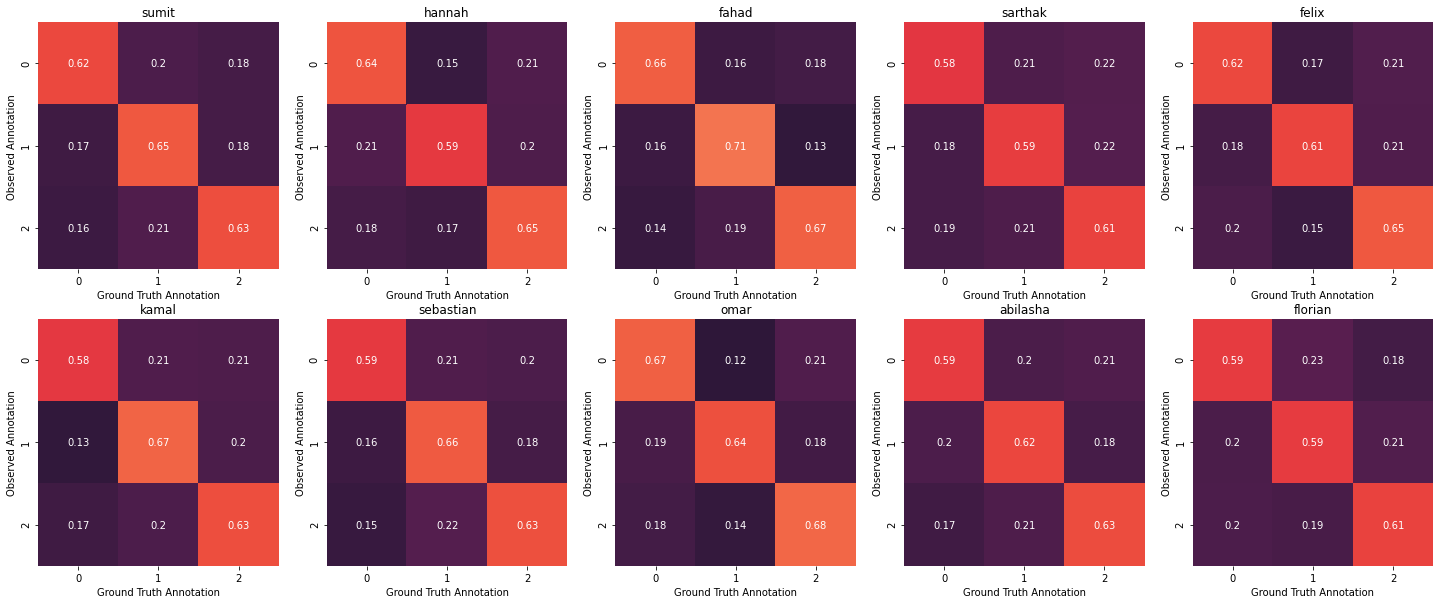

In [8]:
bias_matricesl=[]
k=0
for i in model.parameters():
    k+=1
    if k>3:
        bias_matricesl.append(np.array(i.cpu().detach()))
bias_matrices={}
for i,an in enumerate(dataset.annotators):
    bias_matrices[an]=bias_matricesl[i]
draw_matrices(bias_matrices)

# Get Confusion Matrices Based on Training Set (Without Dawid-Skene)

In [9]:
def prepare_input(dataset):
    data = {}
    ans = dataset.annotators
    for data_point in dataset:
        annotator = data_point['annotator']
        text = data_point['text']
        annotation = data_point['label'].item()
        
        if text not in data:
            data[text] = {}
        data[text][annotator] = [ annotation ]
        preds={}
        for i, an in enumerate(ans):
            preds[an]=model.cpu()(data_point['embedding'])[i].argmax().item()
        data[text]['predictions']=preds
        
    return data

In [10]:
data = prepare_input(dataset)

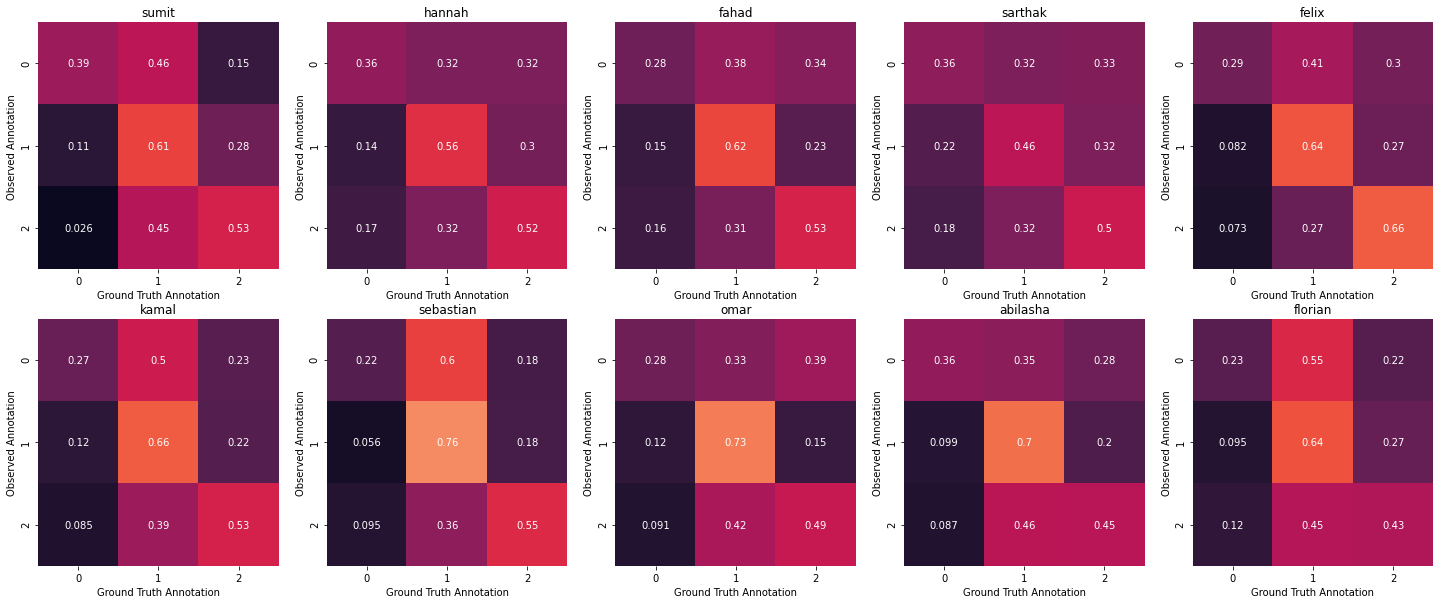

In [11]:
confusion_matrices={}
for an in dataset.annotators:
    conf_matrice=x = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], np.float)
    for sen in data:
        if an==list(data[sen].keys())[0]:
            pred=data[sen]['predictions'][an]
            act=data[sen][an][0]
            conf_matrice[act][pred]+=1
        else:
            continue
    confusion_matrices[an]=conf_matrice
for an in confusion_matrices:
    matrice=confusion_matrices[an]
    for i,m in enumerate(matrice):
        sumofrow=0
        for m2 in m:
            sumofrow+=m2
        m[0]/=sumofrow
        m[1]/=sumofrow
        m[2]/=sumofrow
        matrice[i]=m
    confusion_matrices[an]=matrice
draw_matrices(confusion_matrices)

# Get Confusion Matrices Based on Training Set (With Fast Dawid-Skene)

In [12]:
def prepare_input_for_ds(dataset):
    data = {}
    ans = dataset.annotators
    for data_point in dataset:
        annotator = data_point['annotator']
        text = data_point['text']
        annotation = data_point['label'].item()
        
        if text not in data:
            data[text] = {}
        for i, an in enumerate(ans):
            data[text][an]=[model.cpu()(data_point['embedding'])[i].argmax().item()]
        
    return data

In [13]:
data=prepare_input_for_ds(dataset)

In [14]:
args={}
args['algorithm']='FDS'
args['verbose']=True
patients, observers, classes, counts, class_marginals, error_rates, patient_classes = ds.run(data,args)

Number of Questions: 3544
Number of Participants: 10
Classes: [0, 1, 2]
Iter	log-likelihood	delta-CM	delta-ER
1 	 -8278.833782650603
2 	 -8247.80761032738 	0.006772	0.276446
3 	 -8247.528627162908 	0.000564	0.028787
4 	 -8247.528627162908 	0.000000	0.000000
Class marginals
[0.17 0.49 0.34]
here


In [15]:
def prepare_input_for_cf_ds(dataset, predictions):
    data = {}
    for ik,data_point in enumerate(dataset):
        annotator = data_point['annotator']
        text = data_point['text']
        annotation = data_point['label'].item()
        pred=predictions[ik]
        if text not in data:
            data[text] = {}
        data[text][annotator] = [ annotation ]
        preds={}
        preds[annotator]=pred
        data[text]['predictions']=preds
        
    return data


In [16]:
data=prepare_input_for_cf_ds(dataset, patients)

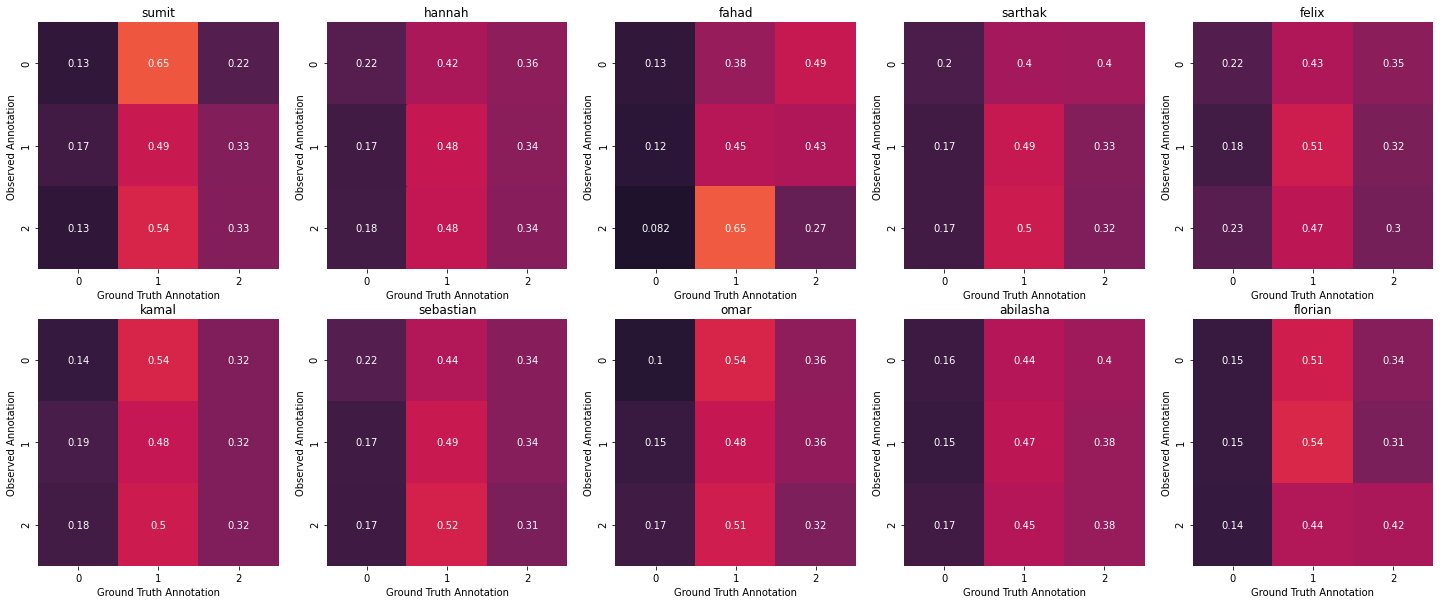

In [17]:
confusion_matrices={}
for an in dataset.annotators:
    conf_matrice=x = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], np.float)
    for sen in data:
        if an==list(data[sen].keys())[0]:
            pred=data[sen]['predictions'][an]
            act=data[sen][an][0]
            conf_matrice[act][pred]+=1
        else:
            continue
    confusion_matrices[an]=conf_matrice
for an in confusion_matrices:
    matrice=confusion_matrices[an]
    for i,m in enumerate(matrice):
        sumofrow=0
        for m2 in m:
            sumofrow+=m2
        m[0]/=sumofrow
        m[1]/=sumofrow
        m[2]/=sumofrow
        matrice[i]=m
    confusion_matrices[an]=matrice
draw_matrices(confusion_matrices)

# Bias Matrices for Spammer Detection

In [18]:
#if you have no gpu
#model = torch.load('src_spammer',map_location=torch.device('cpu'))
#if you have gpu
model = torch.load('src_spammer')
model.eval()

Ipa2ltHead(
  (basic_network): BasicNetwork(
    (attention): Linear(in_features=50, out_features=1, bias=False)
    (classifier): Linear(in_features=50, out_features=3, bias=True)
    (softmax_batch): Softmax(dim=1)
    (softmax): Softmax(dim=0)
    (sigmoid): Sigmoid()
  )
  (bias_matrices): ModuleList(
    (0): Linear(in_features=3, out_features=3, bias=False)
    (1): Linear(in_features=3, out_features=3, bias=False)
    (2): Linear(in_features=3, out_features=3, bias=False)
    (3): Linear(in_features=3, out_features=3, bias=False)
    (4): Linear(in_features=3, out_features=3, bias=False)
    (5): Linear(in_features=3, out_features=3, bias=False)
    (6): Linear(in_features=3, out_features=3, bias=False)
    (7): Linear(in_features=3, out_features=3, bias=False)
    (8): Linear(in_features=3, out_features=3, bias=False)
    (9): Linear(in_features=3, out_features=3, bias=False)
  )
)

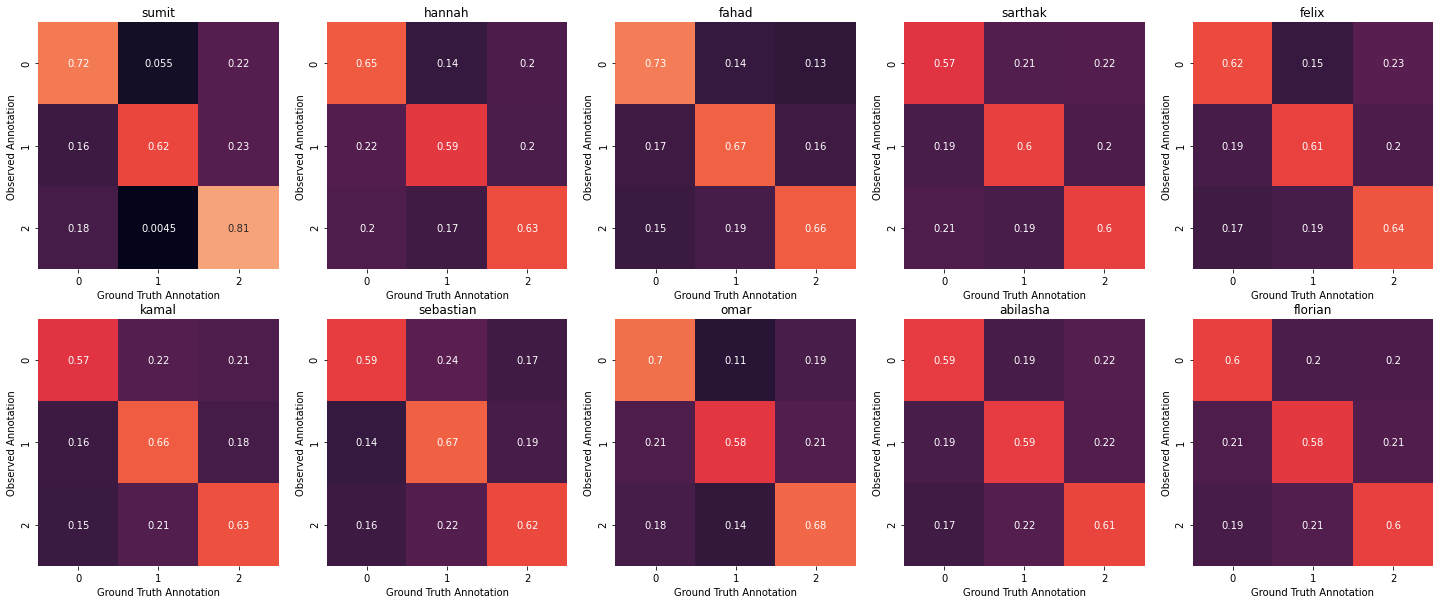

In [19]:
bias_matricesl=[]
k=0
for i in model.parameters():
    k+=1
    if k>3:
        bias_matricesl.append(np.array(i.cpu().detach()))
bias_matrices={}
for i,an in enumerate(dataset.annotators):
    bias_matrices[an]=bias_matricesl[i]
draw_matrices(bias_matrices)